## Generalized Orbital Amplitudes

This tutorial demonstrates how to obtain the generalized orbital amplitudes (GOAs) or Feynman-Dyson orbitals from the solutions to the Extended Koopmans' Theorem (EKT). The GOAs arise, for example, when modelling the intensities of transitions observed in photoelectron spectroscopy. As evaluated from EKT they provide a similar one-electron description to the molecular orbitals useful for interpretation of molecular structure and bonding. This is especially valuable for correlated electronic	structure methods where the orbital picture is otherwise obscure.

In this tutorial we will:
1. Specify a molecular system
2. Calculate its ionization spectrum with EKT
3. Evaluate the GOAs
4. Visualize the GOAs by creating a countour plot

Through this notebook the CO molecule will be used as an example.

### 1. Specify the molecular system

We use [IOData](https://iodata.readthedocs.io/en/latest/) to load the atomic coordinates and the molecular orbitals needed latter on for the evaluation of the GOAs. The molecular orbitals were obtained from a previous calculation at the HF/6-31G level of theory.

In [1]:
# Import statements
import numpy as np
from iodata import load_one
from eomee.tools import find_datafiles


# Load the molecular coordinates and MOs
mol = load_one(find_datafiles("co_631g.molden"))
mo_coeffs = mol.mo.coeffs                        # (nAOs, nMOs)
mo_coeffs_ab = np.hstack((mo_coeffs, mo_coeffs)) # Spin-up orbital, and spin-down MO coeffs


# Print information about the molecule
print("Atomic numbers \n", mol.atnums)
print("Atomic coordinates \n", mol.atcoords)

Atomic numbers 
 [6 8]
Atomic coordinates 
 [[0.         0.         0.        ]
 [2.13161107 0.         0.        ]]


### 2. Find the CO ionization energies

The ionization potentials and corresponding orbital amplitudes for the CO molecule are found running an EKT calculation.
In this tutorial the 1- and 2-RDMs neded by EKT come from an HCI calculation with the 6-31G basis set and epsilon variable of $5 \times 10^{-4}$ (HCI stands for the Heat-Bath Configuration Interaction wavefunction method).
The necesary input parameters for EKT are defined in the following cell.

In [2]:
from eomee.tools import spinize, spinize_rdms


# Load the one- and two-electron integrals in the restricted MO basis
one_int = np.load(find_datafiles("co_631g_oneint.npy"))
two_int = np.load(find_datafiles("co_631g_twoint.npy"))
norba = one_int.shape[0]

# Load the 1- and 2-RDMs for the HCI wfn model (non-zero spin blocks only)
dm1 = np.load(find_datafiles("co_631g_hci_5e-4_1dm.npy")) # (aa, bb)
dm2 = np.load(find_datafiles("co_631g_hci_5e-4_2dm.npy")) # (aa, bb, ab)

# # Uncomment the following lines to generate the 1- and 2-RDMs for the Hartree-Fock wfn model instead
# # of the HCI one.
# from eomee.tools import hartreefock_rdms
# nelecs = (7,7) # Number of alpha and beta electrons in the CO molecule
# rdm1, rdm2 = hartreefock_rdms(norba, *nelecs)

# Conver electron integrals and RDMs to the generalized orbital basis
oneint = spinize(one_int) # (k,k) --> (2k, 2k) matrix dimensions
twoint = spinize(two_int) # (k,k,k,k) --> (2k, 2k, 2k, 2k) array dimensions
rdm1 = spinize_rdms(dm1)
rdm2 = spinize_rdms(dm2)


print("Number of basis functions \n", norba)
print("Number of electrons \n", np.trace(dm1[0] + dm1[1]))
print("Spinized one int dimensions: ", oneint.shape)
print("Spinized 1RDM dimensions: ", rdm1.shape)

Number of basis functions 
 18
Number of electrons 
 13.999999999999982
Spinized one int dimensions:  (36, 36)
Spinized 1RDM dimensions:  (36, 36)


In [3]:
# nto_o, w, nto_vT = np.linalg.svd(rdm1)
# occupied_nto = np.dot(mo_coeffs_ab, nto_o)
# print(w)

In [4]:
from eomee.eomip import IP

# Build de EKT matrix equation
ekt = IP(oneint, twoint, rdm1, rdm2)

# Solve the EOM eigenvalue problem
ev, cv = ekt.solve_dense()

# Print the first 5 ionization energies
print("{0:<2s} {1:<6s}".format('n', 'EDiff.(a.u.)'))
for i, e in enumerate(ev[:10]):
    print("{0:<2} {1:<6.3}".format(i, e*27.12))

              These will be removed from the final solution set.
n  EDiff.(a.u.)
0  13.7  
1  13.7  
2  17.3  
3  17.3  
4  20.5  
5  20.5  
6  32.2  
7  32.2  
8  36.7  
9  36.7  


### 3. Evaluate the GOAs

Once the IPs and corresponding transition coefficients are obtained, the approximate GOAs can be generated using the following formula:

<!-- Approximate Dyson orbitlas (or generalized orbital amplitudes, GOA) -->

$$g^{EKT}_k (x)= \sum_j c_{jk} n^{-1/2}_j \chi_j (x)$$

$c_{jk}$ coefﬁcients are the eigenvector solutions to EKT  
$n_j$ are the natural spin orbital occupation numbers  
$\chi_j$ are the natural orbitals

In [5]:
# Select one of the (N-1) ionized states to evaluate the GOAs.
# We will select the first ionized state corresponding to an electron with alpha spin being removed.
state_idx = 1

# Compute the GOA coefficients
natorb_occs = np.diag(rdm1)
ncv = np.sqrt(natorb_occs) * cv[state_idx]
goa_coeffs = np.einsum("ni,i->ni", mo_coeffs_ab, ncv)


# Check the spin-orbitals with highest transition amplitudes for the selected ionized state
spins_indx = np.where(np.abs(ncv) > 0.01)
print("Spin-orbital components of the eigenvector \n", spins_indx[0])
print("Transition amplitudes \n", ncv[spins_indx])

Spin-orbital components of the eigenvector 
 [ 6 12 17]
Transition amplitudes 
 [ 0.28675253  0.06261803 -0.01400078]


### 4. Visualize the GOAs

To visualize the GOAs we generate a 2-D grid of points and evaluate the orbitals on the grid points using [GBasis](https://gbasis.qcdevs.org/intro.html).

In [6]:
# Create a planar grid for the molecule
coord_limit = 5
plt_pts = 40
plt_lmts = [-coord_limit, coord_limit, -coord_limit, coord_limit]
x_vals = np.linspace(-coord_limit, coord_limit, plt_pts)
y_vals = x_vals

# Sample 3D points uniformly in the molecular xy-plane (z=0)
x_vals, y_vals = np.meshgrid(x_vals, y_vals)
x_vals, y_vals = x_vals.flatten(), y_vals.flatten()
z_vals = np.zeros_like(x_vals)
points = np.array([x_vals, y_vals, z_vals]).T  # gbasis evaluates at 3D points

print(f"Number of points in the planar grid: {len(points)}")

Number of points in the planar grid: 1600


In [7]:
from gbasis.wrappers import from_iodata
from gbasis.evals.density import evaluate_basis

# Evaluate the GOAs in the grid points using GBasis
ao_basis = from_iodata(mol)
mo_vals = evaluate_basis(ao_basis, points, transform=goa_coeffs[:,:norba].T)

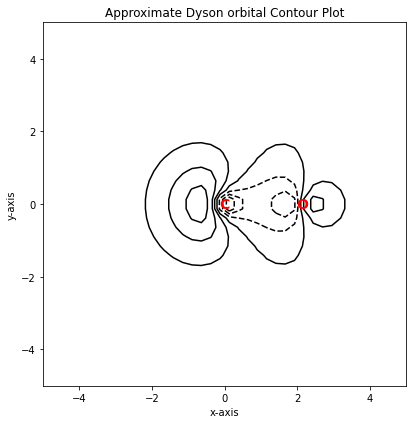

In [8]:
import matplotlib.pyplot as plt

# Pick an orbital for the Isosurface
idx = 6
homo_vals = mo_vals[idx, :]

# plot the GOA as contour plot
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(111, aspect="equal")
ax1.set_title("Approximate Dyson orbital Contour Plot")
ax1.set_xlabel("x-axis")
ax1.set_ylabel("y-axis")

X = points[:, 0].reshape(plt_pts, plt_pts)
Y = points[:, 1].reshape(plt_pts, plt_pts)
Z = homo_vals.reshape(plt_pts, plt_pts)
# Add contour plot of the GOA
cs = ax1.contour(X, Y, Z, levels=np.linspace(-0.1, 0.1, 7), colors="k")
# Add atomic symbols to the plots
symbols = ["C", "O"]
xy_coords = mol.atcoords[:, :2]
for coord, symbol in zip(xy_coords, symbols):
    ax1.text(
        coord[0],
        coord[1],
        symbol,
        color="red",
        ha="center",
        va="center",
        fontsize=14,
        fontweight="bold",
    )

plt.tight_layout()  # Adjust layout for better spacing
plt.show()